In [1]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt
from scipy.signal import czt
import csv
import pywt


In [2]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]


In [3]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

In [4]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]
first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)


3072000
(6000, 512)


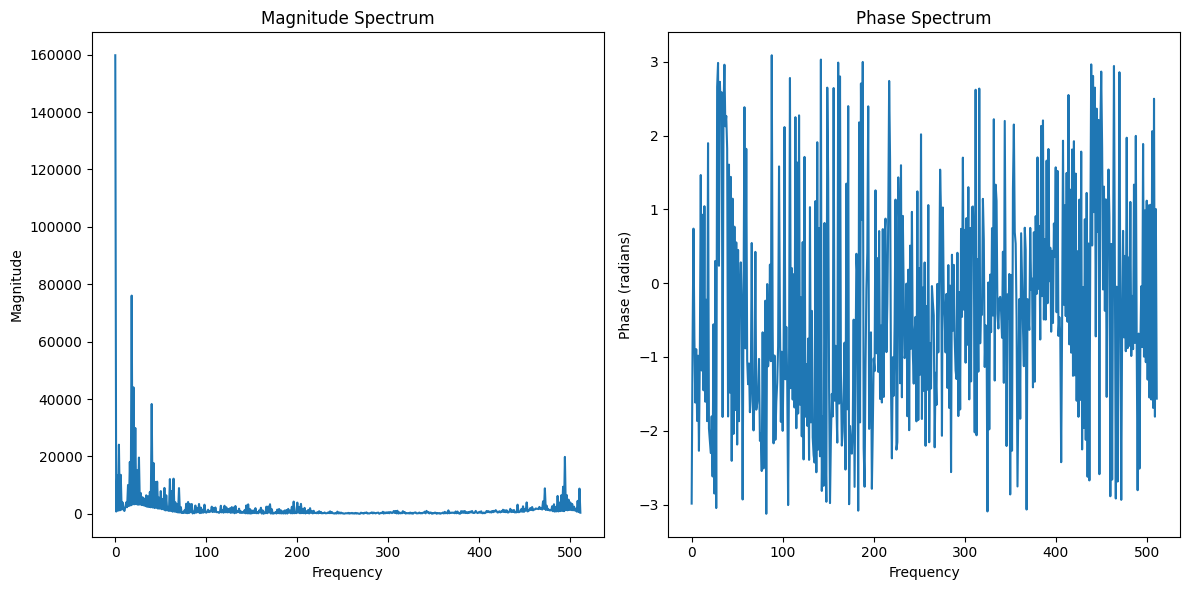

In [5]:
complex_range_profiles = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
magnitudes = [np.abs(complex_range_profile) for complex_range_profile in complex_range_profiles]
angles = [np.angle(complex_range_profile) for complex_range_profile in complex_range_profiles]
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(magnitudes[0])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum')

plt.subplot(122)
plt.plot(angles[0])
plt.xlabel('Frequency')
plt.ylabel('Phase (radians)')
plt.title('Phase Spectrum')

plt.tight_layout()

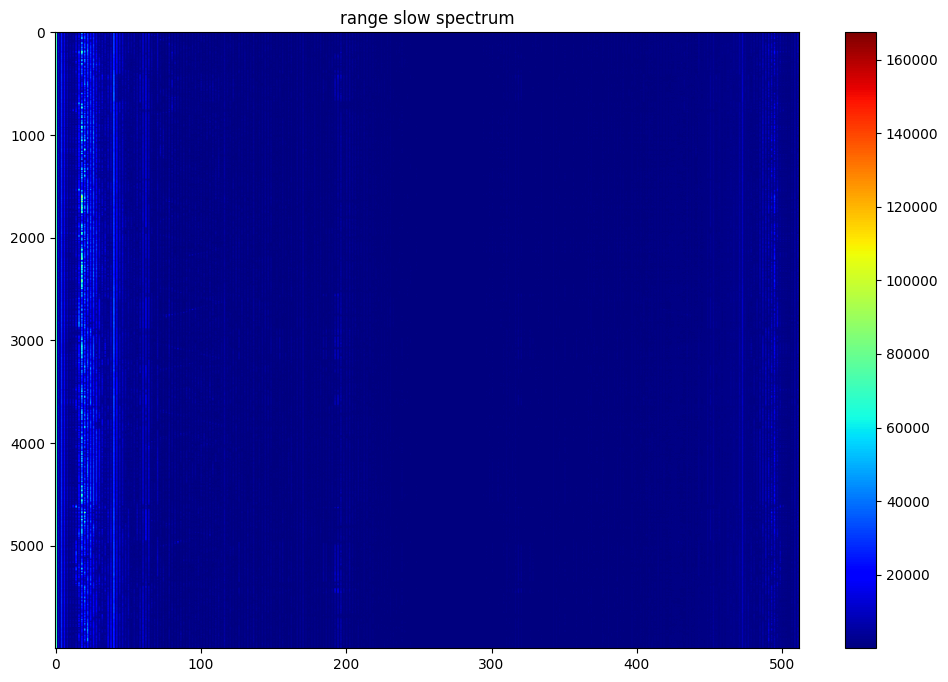

In [7]:
# range-slow time matrix
range_slow_time_m_x_n = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
range_slow_time_m_x_n_spectrum = [np.abs(profile) for profile in range_slow_time_m_x_n]
plt.figure(figsize=(12,8))
plt.imshow(range_slow_time_m_x_n_spectrum,cmap='jet',aspect='auto')
plt.colorbar()
plt.title("range slow spectrum")
plt.show()

In [8]:
# calculate DC 
corrected_range_slow_time_m_x_n = np.empty(shape=np.array(range_slow_time_m_x_n).shape, dtype=complex)
range_bins=np.array(range_slow_time_m_x_n).shape[1]
DC_ranges=  np.empty(range_bins, dtype='object')
for r_th in range(0,range_bins):
    
    range_bin_r_th =np.array(range_slow_time_m_x_n)[:,r_th]
    avg_re_I= np.mean(np.real(range_bin_r_th))
    avg_im_Q= np.mean(np.imag(range_bin_r_th))
    DC_ranges[r_th]=avg_re_I +  avg_im_Q*1j


In [9]:
print(np.array(DC_ranges).shape)

(512,)


In [10]:
#DC correction
for i_th in range(0,range_bins):
    DC=DC_ranges[i_th]    
    corrected_range_slow_time_m_x_n[:,i_th] = np.array(range_slow_time_m_x_n)[:,i_th] -DC
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


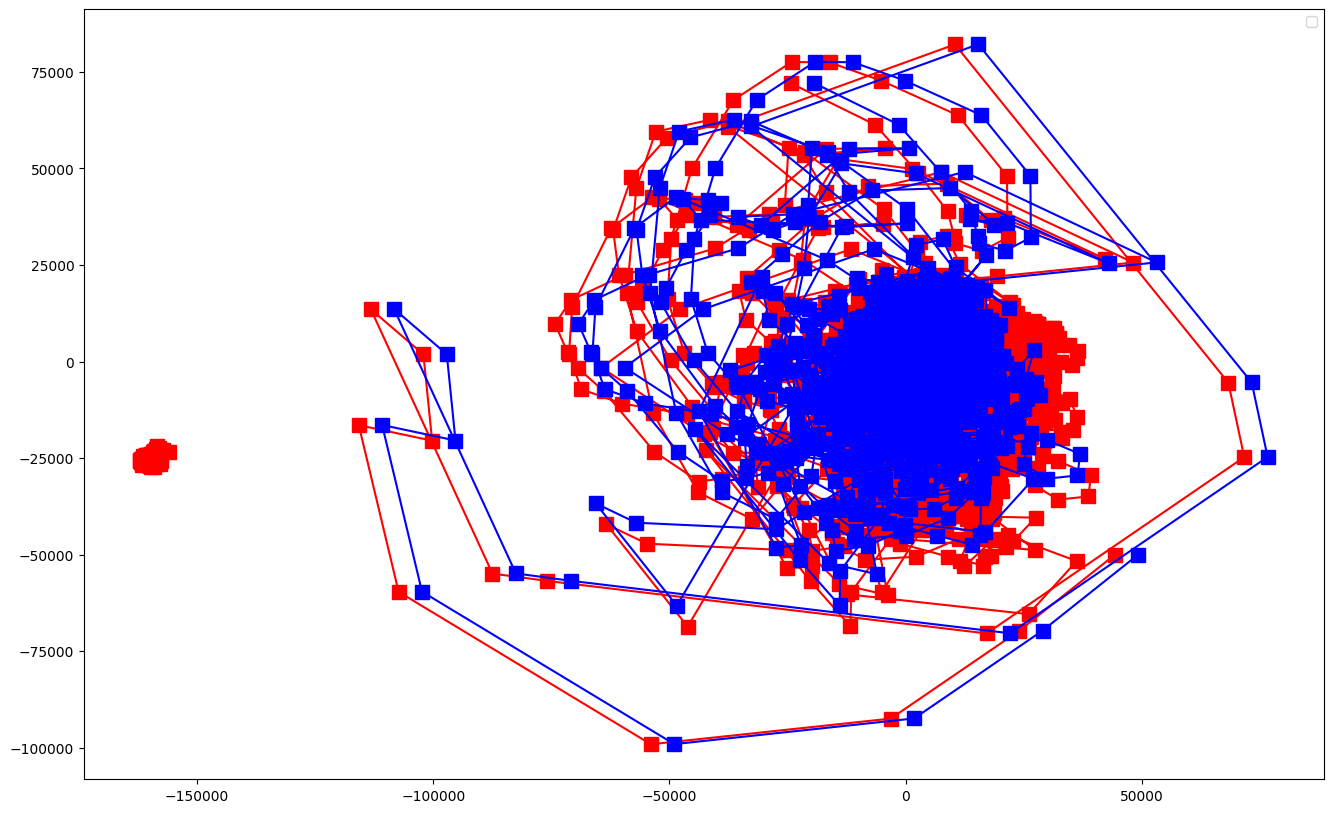

In [35]:
tmp_org_range_slow_time_m_x_n =range_slow_time_m_x_n[0:200]
DC_real_parts = [z.real for z in tmp_org_range_slow_time_m_x_n]
DC_imaginary_parts = [z.imag for z in tmp_org_range_slow_time_m_x_n]

tmp_range_slow_time_m_x_n =corrected_range_slow_time_m_x_n[0:200]
DC_corrected_real_parts = [sl.real for sl in tmp_range_slow_time_m_x_n]
DC_corrected_imaginary_parts = [sl.imag for sl in tmp_range_slow_time_m_x_n]



plt.figure(figsize=(16, 10))

plt.plot(DC_real_parts, DC_imaginary_parts, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_real_parts, DC_imaginary_parts, color='red')

plt.plot(DC_corrected_real_parts, DC_corrected_imaginary_parts, 'bs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_corrected_real_parts, DC_corrected_imaginary_parts, color='blue')
plt.legend()
plt.show()


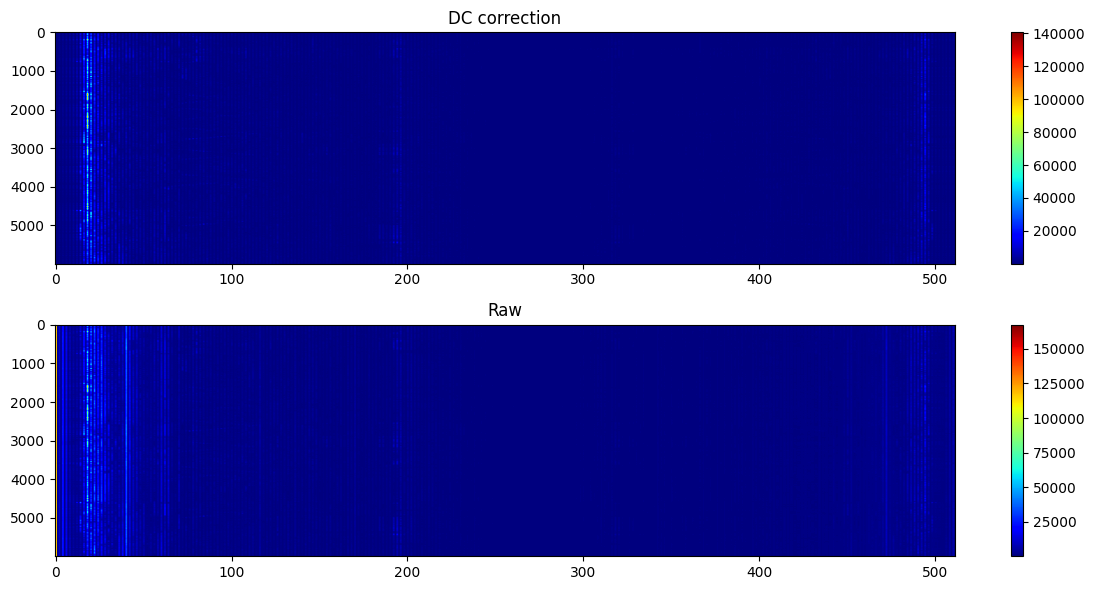

In [12]:
magnitude_corrected_ffts = [np.abs(corrected_fft) for corrected_fft in corrected_range_slow_time_m_x_n]
magnitude_org_ffts = [np.abs(org) for org in range_slow_time_m_x_n]

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.imshow(magnitude_corrected_ffts, cmap='jet', aspect='auto')
plt.colorbar()
plt.title("DC correction")

plt.subplot(2,1,2)
plt.imshow(magnitude_org_ffts, cmap='jet', aspect='auto')
plt.title("Raw")
plt.colorbar()
plt.tight_layout()

plt.show()

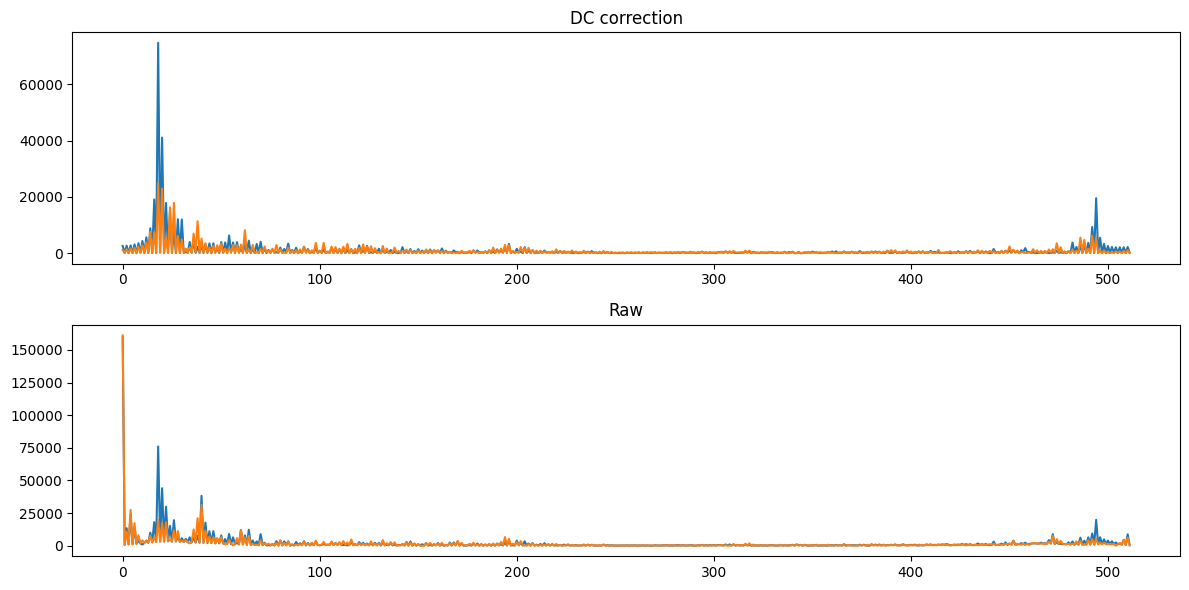

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.title("DC correction")
plt.plot(magnitude_corrected_ffts[0])
plt.plot(magnitude_corrected_ffts[1])
plt.plot(magnitude_corrected_ffts[-1])

plt.subplot(2,1,2)
plt.title("Raw")
plt.plot(magnitude_org_ffts[0])
plt.plot(magnitude_org_ffts[-1])
plt.tight_layout()
plt.show()


In [21]:
unwrapped_corrected_range_slow_time_m_x_n = np.zeros_like(corrected_range_slow_time_m_x_n)
for j_th in range(0,range_bins):
    print("unwrap the ",j_th," bin")   
    unwrapped_corrected_range_slow_time_m_x_n[:,i_th] = np.unwrap(np.angle(corrected_range_slow_time_m_x_n)[:,i_th])

unwrap the  0  bin
unwrap the  1  bin
unwrap the  2  bin
unwrap the  3  bin
unwrap the  4  bin
unwrap the  5  bin
unwrap the  6  bin
unwrap the  7  bin
unwrap the  8  bin
unwrap the  9  bin
unwrap the  10  bin
unwrap the  11  bin
unwrap the  12  bin
unwrap the  13  bin
unwrap the  14  bin
unwrap the  15  bin
unwrap the  16  bin
unwrap the  17  bin
unwrap the  18  bin
unwrap the  19  bin
unwrap the  20  bin
unwrap the  21  bin
unwrap the  22  bin
unwrap the  23  bin
unwrap the  24  bin
unwrap the  25  bin
unwrap the  26  bin
unwrap the  27  bin
unwrap the  28  bin
unwrap the  29  bin
unwrap the  30  bin
unwrap the  31  bin
unwrap the  32  bin
unwrap the  33  bin
unwrap the  34  bin
unwrap the  35  bin
unwrap the  36  bin
unwrap the  37  bin
unwrap the  38  bin
unwrap the  39  bin
unwrap the  40  bin
unwrap the  41  bin
unwrap the  42  bin
unwrap the  43  bin
unwrap the  44  bin
unwrap the  45  bin
unwrap the  46  bin
unwrap the  47  bin
unwrap the  48  bin
unwrap the  49  bin
unwrap the

In [22]:
fft_unwrapped_corrected_range_slow_time_m_x_n = np.empty(shape=np.array(unwrapped_corrected_range_slow_time_m_x_n).shape,dtype=complex)
mag_unwrapped_corrected_range_slow_time_m_x_n = np.empty(shape=np.array(unwrapped_corrected_range_slow_time_m_x_n).shape,dtype=float)
for j_th in range(0,range_bins):
    fft_unwrapped_corrected_range_slow_time_m_x_n[:,i_th] = np.fft.fft(unwrapped_corrected_range_slow_time_m_x_n[:,i_th])
    mag_unwrapped_corrected_range_slow_time_m_x_n[:,i_th] =np.abs(fft_unwrapped_corrected_range_slow_time_m_x_n[:,i_th])


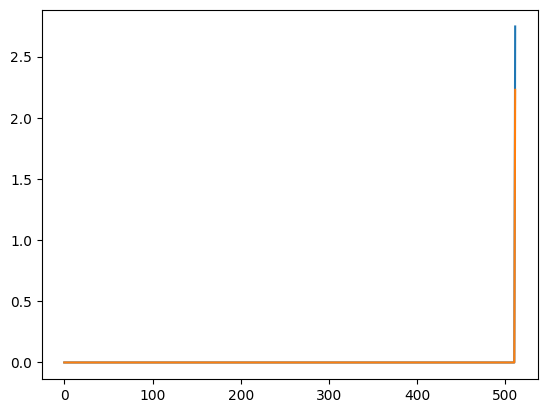

In [26]:
plt.plot(unwrapped_corrected_range_slow_time_m_x_n[0])
plt.plot(unwrapped_corrected_range_slow_time_m_x_n[1])

300.0


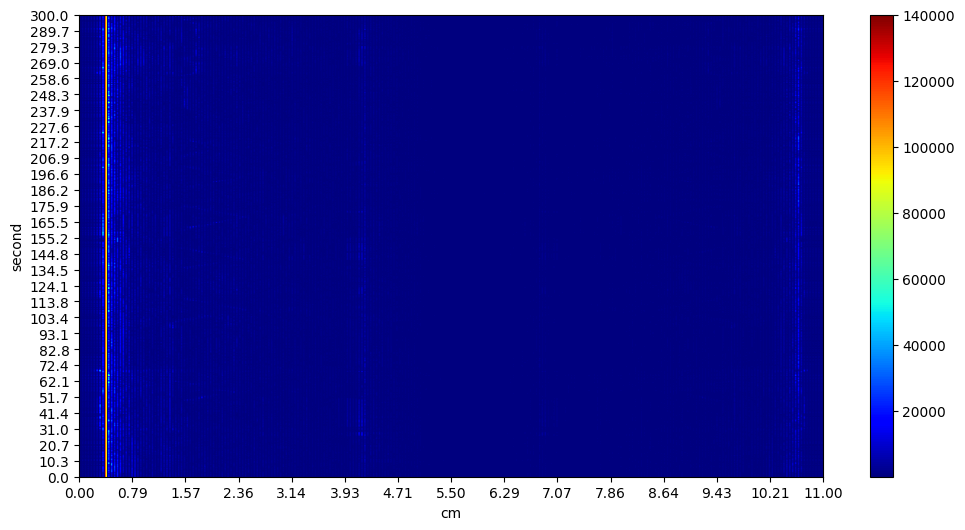

In [18]:
tmp_array= copy.deepcopy(magnitude_corrected_ffts)
for _i,tmp in enumerate(tmp_array):
    tmp[bin_of_interest]=140000
    # tmp[bin_of_interest+1]=140000
    # tmp[bin_of_interest+2]=140000

   

plt.figure(figsize=(12, 6))
xmin=0
xmax=11
x = np.linspace(xmin, xmax, 15)
ymin=0
ymax=len(tmp_array)/20 #6000 chirp ~6000 frame each second has 20 frame -> second
#ymax ~300s ~5mins
print(ymax)
y = np.linspace(ymin, ymax, 30)
plt.xticks(x)
plt.yticks(y)

plt.imshow(tmp_array, cmap='jet', aspect='auto',extent=[xmin,xmax,ymin,ymax])
plt.xlabel('cm')
plt.ylabel('second')
plt.colorbar()
plt.show()

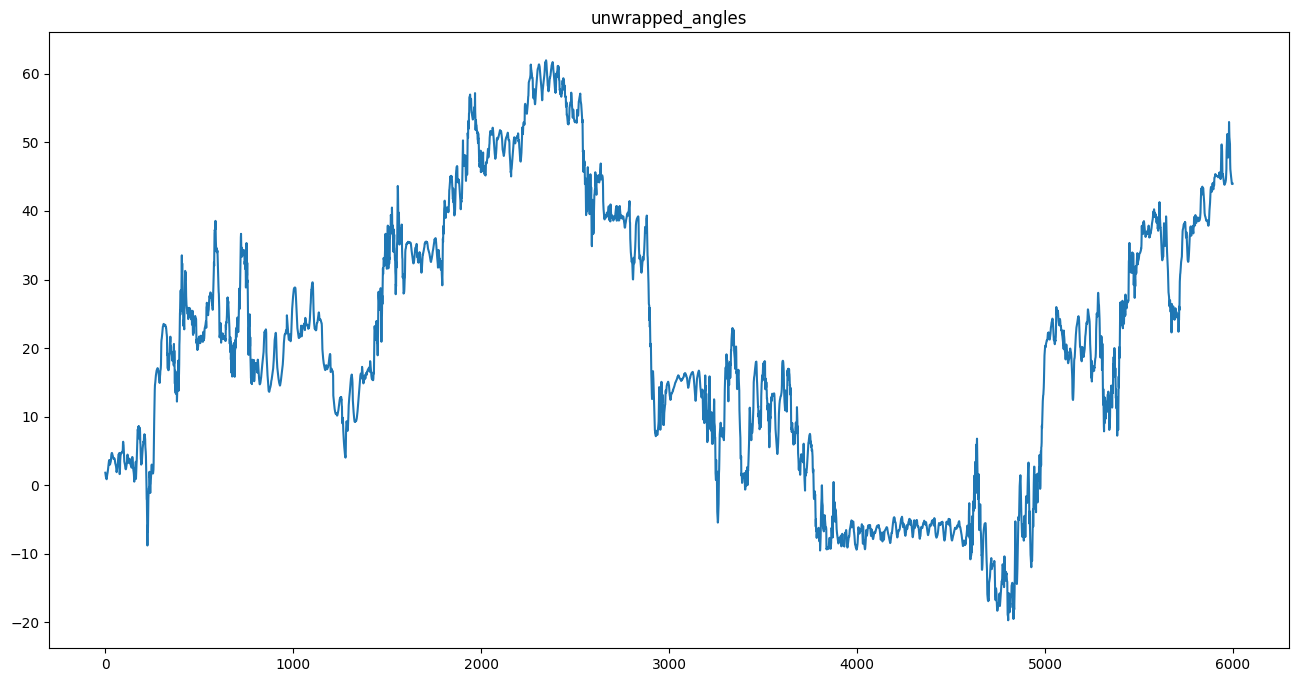

In [19]:
interested_ffts =corrected_range_slow_time_m_x_n[:,bin_of_interest][0:-1]
    
interested_angles = np.angle(np.array(interested_ffts).flatten())
unwrapped_angles=np.unwrap(interested_angles)
plt.figure(figsize=(16,8))
plt.plot(unwrapped_angles)
plt.title("unwrapped_angles")
plt.show()

/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


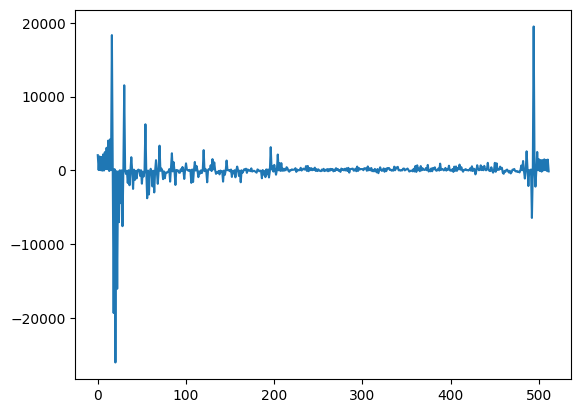

In [28]:
plt.plot(corrected_range_slow_time_m_x_n[0])

In [21]:
unwrapped_corrected_range_slow_time_m_x_n = np.zeros_like(corrected_range_slow_time_m_x_n)
for j_th in range(0,range_bins):
    print("unwrap the ",j_th," bin")   
    unwrapped_corrected_range_slow_time_m_x_n[:,i_th] = np.unwrap(np.angle(corrected_range_slow_time_m_x_n)[:,i_th])

unwrap the  0  bin
unwrap the  1  bin
unwrap the  2  bin
unwrap the  3  bin
unwrap the  4  bin
unwrap the  5  bin
unwrap the  6  bin
unwrap the  7  bin
unwrap the  8  bin
unwrap the  9  bin
unwrap the  10  bin
unwrap the  11  bin
unwrap the  12  bin
unwrap the  13  bin
unwrap the  14  bin
unwrap the  15  bin
unwrap the  16  bin
unwrap the  17  bin
unwrap the  18  bin
unwrap the  19  bin
unwrap the  20  bin
unwrap the  21  bin
unwrap the  22  bin
unwrap the  23  bin
unwrap the  24  bin
unwrap the  25  bin
unwrap the  26  bin
unwrap the  27  bin
unwrap the  28  bin
unwrap the  29  bin
unwrap the  30  bin
unwrap the  31  bin
unwrap the  32  bin
unwrap the  33  bin
unwrap the  34  bin
unwrap the  35  bin
unwrap the  36  bin
unwrap the  37  bin
unwrap the  38  bin
unwrap the  39  bin
unwrap the  40  bin
unwrap the  41  bin
unwrap the  42  bin
unwrap the  43  bin
unwrap the  44  bin
unwrap the  45  bin
unwrap the  46  bin
unwrap the  47  bin
unwrap the  48  bin
unwrap the  49  bin
unwrap the

In [22]:
fft_unwrapped_corrected_range_slow_time_m_x_n = np.empty(shape=np.array(unwrapped_corrected_range_slow_time_m_x_n).shape,dtype=complex)
mag_unwrapped_corrected_range_slow_time_m_x_n = np.empty(shape=np.array(unwrapped_corrected_range_slow_time_m_x_n).shape,dtype=float)
for j_th in range(0,range_bins):
    fft_unwrapped_corrected_range_slow_time_m_x_n[:,i_th] = np.fft.fft(unwrapped_corrected_range_slow_time_m_x_n[:,i_th])
    mag_unwrapped_corrected_range_slow_time_m_x_n[:,i_th] =np.abs(fft_unwrapped_corrected_range_slow_time_m_x_n[:,i_th])


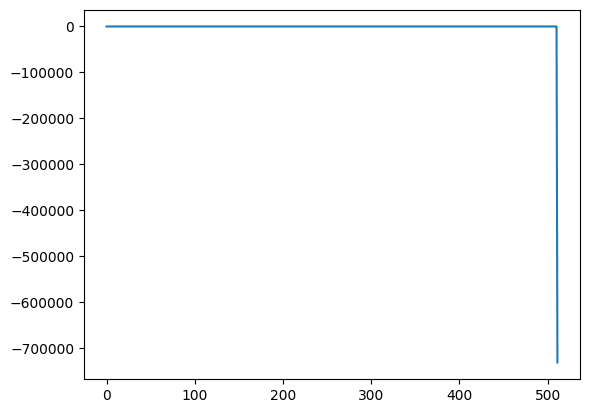

In [27]:
plt.plot(fft_unwrapped_corrected_range_slow_time_m_x_n[0])

In [23]:
mag_unwrapped_indices = np.zeros(shape=len(mag_unwrapped_corrected_range_slow_time_m_x_n))
for  corr_spectrum in mag_unwrapped_corrected_range_slow_time_m_x_n:
    corr_max_index=np.argmax(np.abs(corr_spectrum))
    mag_unwrapped_indices[corr_max_index]+=1
corr_max_bin = max(mag_unwrapped_indices)
corr_bin_of_interest = np.where(corr_max_bin ==mag_unwrapped_indices )[0]

for i,val in enumerate(mag_unwrapped_indices):
    if(0!=val):
        print("index:",i," : ",val)
print("bin of interest: ",corr_bin_of_interest)

index: 511  :  6000.0
bin of interest:  [511]


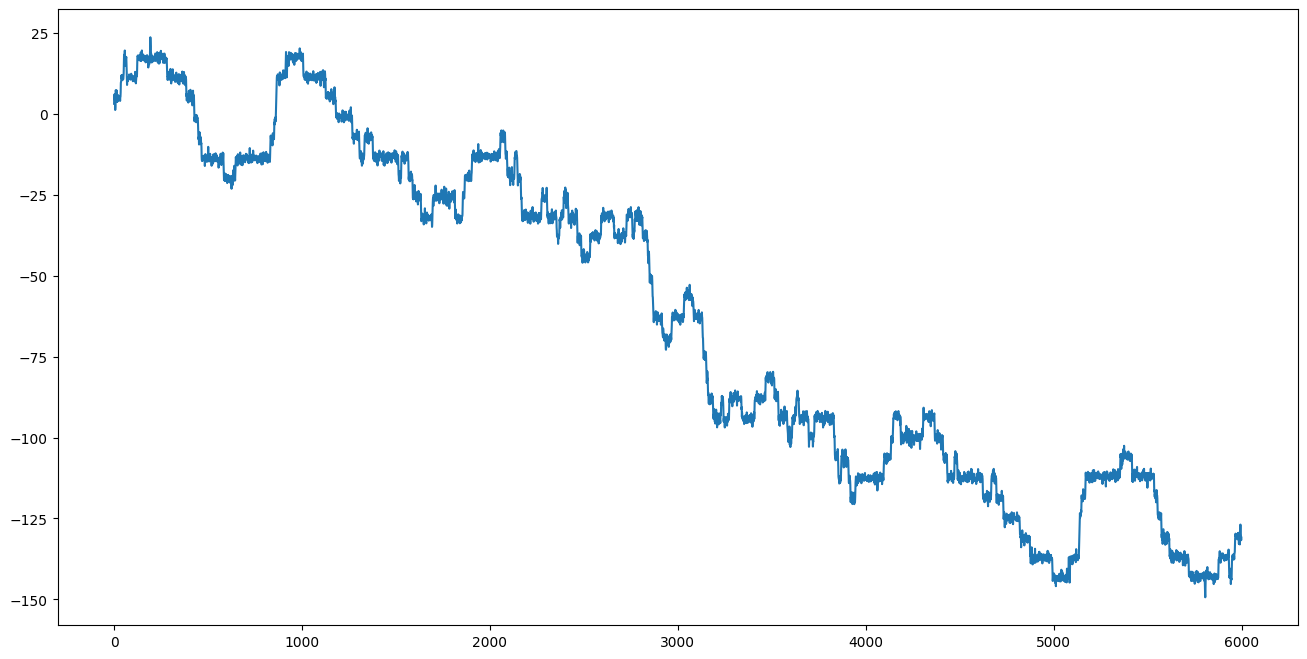

(6000, 512)


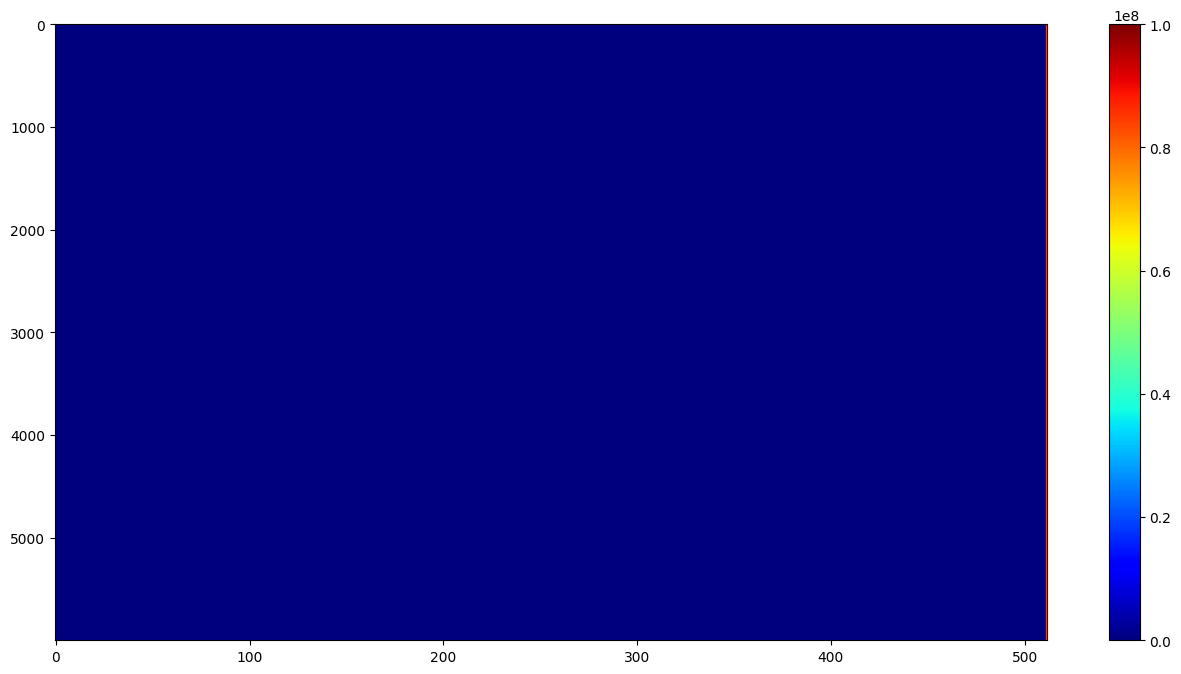

In [24]:
interested_index =corr_bin_of_interest[0]
vital_angles = np.unwrap(np.angle(fft_unwrapped_corrected_range_slow_time_m_x_n[:,interested_index]))
plt.figure(figsize=(16,8))
plt.plot(vital_angles) 
plt.show()
tmp_mag_unwrapped_corrected_range_slow_time_m_x_n = copy.deepcopy(mag_unwrapped_corrected_range_slow_time_m_x_n)
print(tmp_mag_unwrapped_corrected_range_slow_time_m_x_n.shape)

tmp_mag_unwrapped_corrected_range_slow_time_m_x_n[:,interested_index] =1e8

plt.figure(figsize=(16,8))
plt.imshow(tmp_mag_unwrapped_corrected_range_slow_time_m_x_n,cmap='jet',aspect='auto')
plt.colorbar()
plt.show()
